https://colab.research.google.com/drive/1qFmP0Nc2SkQphf8UM3KGtVSG4c3hg2Vp?usp=sharing

# import

In [1]:
import re
import os
import csv
import glob
import base64
import requests
import numpy as np 
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%capture
!pip install --upgrade --no-cache-dir gdown
!pip install tqdm

# Download and prepare data


because I use google colab to run my code
first of all I download my data from google drive
this data was uploaded manualy on google drive and
are publicly available


In [3]:
%%capture
!gdown 1_iQKcOhqtCPrta3Cz0pjbO02C2VaQ4wV -O data.rar
!unrar x "/content/data.rar" "/content/main_content/"

# Preprocess function

## feature extraction

In [7]:
def get_html(url):
    page = requests.get(url).content
    soup = BeautifulSoup(page, "html.parser")
    return soup


def get_html_from_csv(file_path):
    '''
    :input : path of csv file.
    :output: list of soup corresponding to each page
    '''
    html64file = pd.read_csv(file_path, encoding='utf8', nrows=500)
    pages = []
    for i, page_html in html64file.iterrows():
        html_string = base64.b64decode(page_html['html'])
        pages.append(BeautifulSoup(html_string, "html.parser"))

    return pages



def get_title(soup):
    return soup.find('meta', {'property': 'og:title'})["content"]


def title_content_intersection_ratio(title, content):
    intersection = np.intersect1d(title , content)

    if len(content) != 0:
        return len(intersection)/len(content)
    else:
        return 0

In [26]:
def create_page_feature(page):

    content_list = []
    title_similarity = []
    content_depth_list = []
    content_words_number_list = []
    labels = []

    soup = page

    title = get_title(soup)
    title_splited = title.split()
    description = soup.find('meta', {'property': 'og:description'})["content"]

    def traverse(t, current_path=None):
        if current_path is None:
            current_path = [t.name]

        for tag in t.find_all(recursive=False):
            if not tag.find():        
                path = current_path + [tag.name, tag.find(string=True)]
                content = tag.find(string=True)
                content_str = str(content)
                content_splited = content_str.split()
                if content_str != 'None':
                    content = tag.find(string=True).strip()

                    if content_str == description:
                        labels.append(1)
                    elif content_str == title:
                        labels.append(2)
                    else:
                        labels.append(0)
                    
                    content_list.append(content_str)
                    content_depth_list.append(float(len(path)))
                    content_words_number_list.append(len(content_splited))
                    title_similarity.append(\
                            title_content_intersection_ratio
                            (title_splited, content_splited))
                    
            else:
                traverse(tag, current_path + [tag.name])
            

    traverse(soup.body)


    # z score normalize number of words
    content_words_number_list = zscore(content_words_number_list)
    
    df_output = pd.DataFrame({'content': content_list,
                 'content lengh' : [len(c.split()) for c in content_list],
                 'depth': content_depth_list,
                 'title_similarity' : title_similarity ,
                 'words in content': content_words_number_list, 
                 'label': labels} )

    # drop rows when len(content) <= 3
    df_output = df_output[df_output['content lengh']>3]
    # frop rows with title_content_intersection_ratio < 0
    df_output = df_output[df_output["title_similarity"] > 0]

    return df_output

## prepare training data

In [18]:
def prepare_training_data(webpages_path=['/content/main_content/tasnimnews_all.csv']):
    
    features_name = ['content',
                    'content lengh',
                    'depth',
                    'title_similarity',
                    'words in content',
                    'label']
    feature_store = pd.DataFrame(columns=features_name) 
 
    for path in webpages_path:
        feature_store_webpage = pd.DataFrame(columns=features_name) 
        print(path)
        pages = get_html_from_csv(path)
        for page in tqdm(pages):
            try:
                feature_store_webpage = feature_store_webpage.append(create_page_feature(page)) 
            except:
                #When og:description don't appeare in page
                continue
            
            #normal for each website
            feature_store_webpage['normalize_depth'] = zscore(feature_store_webpage['depth'])
        
        feature_store = feature_store.append(feature_store_webpage)

    feature_store.reset_index(drop=True, inplace=True)

    return feature_store

# Training model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Train test split

In [32]:
def train_test_split_(dataset):
    
    dataset[dataset["label"] == 2]["label"] = 0
    dataset['content lengh'] = dataset['content lengh'].astype(int)
    dataset['depth'] = dataset['depth'].astype(int)
    dataset['title_similarity'] = dataset['title_similarity'].astype(float)
    dataset['normalize_depth'] = dataset['normalize_depth'].astype(float)
    dataset['words in content'] = dataset['words in content'].astype(float)
    dataset['label'] = dataset['label'].astype(bool)
    
    X = dataset.drop(['label', 'content'],axis=1)
    y = dataset['label']
    print("labels : ", y.value_counts())
    
    x_train, x_test, y_train, y_test =\
     train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)
    
    return x_train, x_test, y_train, y_test

## Evaluation Metric

In [12]:
def confusion_matrix_(test_labels, predicted_labels, version):
    if not os.path.exists('result'):
        os.makedirs('result')

    print("\nconfusion_matrix\n")
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.subplots(figsize=(10, 6))
    sn.heatmap(cm, annot = True, fmt = 'd', cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(f'confusion_matrix_{version}.png', bbox_inches='tight')

def model_result(y_test,y_pred, version):
    ra_score = roc_auc_score(y_test,y_pred)
    a_score = accuracy_score(y_test,y_pred)
    p_score = precision_score(y_test,y_pred)
    r_score = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    
    print('roc_auc_score : ',ra_score)
    print('accuracy_score: ',a_score)
    print('precision_score: ',p_score)
    print('recall_score: ',r_score)
    print('f1-score :', f1)
    print('confusion_matrix: ',confusion_matrix(y_test,y_pred))
    confusion_matrix_(y_test,y_pred, version)

## ML Classifier

In [13]:
%%capture
!pip install catboost

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.utils import class_weight

def extra_tree_train(x_train, x_test, y_train, y_test):
    clf = ExtraTreesClassifier(n_estimators=10, criterion='entropy')
    #Train the model using the training sets
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test.fillna(0))
    model_result(y_test,y_pred, version='ExtraTreesClassifier_entropy')



def random_forest_classifier(x_train, x_test, y_train, y_test):
    random_forest_clf = RandomForestClassifier(max_depth=20)
    #Train the model using the training sets
    random_forest_clf.fit(x_train, y_train)
    y_pred = random_forest_clf.predict(x_test.fillna(0))
    model_result(y_test,y_pred, version='RandomForestClassifier')



def catboost_classifier(x_train, x_test, y_train, y_test):
    # initializing the model
    cbc = CatBoostClassifier(iterations=100, max_depth=16)

    # training the model
    cbc.fit(x_train, y_train)
    y_pred = cbc.predict(x_test)
    model_result(y_test,y_pred, version='CatBoostClassifier')


def xgboost_classifier(x_train, x_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(x_train, y_train)
    y_pred = xgb_cl.predict(x_test)
    model_result(y_test,y_pred, version='XGBClassifier')
    print(xgb_cl.feature_importances_)
    return xgb_cl

def SVM_classifier(x_train, x_test, y_train, y_test):
    # define outlier detection model
    weight = class_weight.compute_class_weight\
    (class_weight ='balanced', classes = np.unique(y_train), y = y_train)
    weights = {i : weight[i] for i in range(2)}

    svm_model = SVC(class_weight = weights)
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    model_result(y_test,y_pred, version='SVMClassifier')

# Main

In [ ]:
# webpage_path_list = glob.glob(os.path.join('/content/main_content','*_all.csv'))
webpage_path_list = ['/content/main_content/isna_all.csv']

In [28]:
%%time
warnings.filterwarnings("ignore")
dataset = prepare_training_data(webpage_path_list)

/content/main_content/isna_all.csv


100%|██████████| 500/500 [00:23<00:00, 21.22it/s]

CPU times: user 1min 43s, sys: 964 ms, total: 1min 44s
Wall time: 1min 46s


In [29]:
dataset

,content,content lengh,depth,title_similarity,words in content,label,normalize_depth
0,وزیر ارشاد از چه کسی فروتنانه تقدیر کرد؟,8,13.0,0.125000,0.470607,0,0.081588
1,پایان جشنواره های فجر ۱۴۰۱ با یاد بابک برزویه ...,18,13.0,0.055556,1.809702,0,0.081588
2,اختصاص بیش از 10 میلیارد تومان برای اجرای 240 ...,14,12.0,1.000000,1.274064,2,-0.796745
3,مجید بیکی، امروز چهارشنبه 27 فروردین در جلسه ب...,72,12.0,0.097222,9.040812,0,-0.796745
4,به گزارش ایسنا، وی گفت: سرجمع اعتبارات سال 98 ...,38,12.0,0.131579,4.487891,0,-0.796745
...,...,...,...,...,...,...,...
13398,دستور وزیر صمت به شرکت‌های بزرگ صنعتی و معدنی ...,13,13.0,0.076923,0.552257,0,0.081588
13399,آمادگی شهرداری تهران برای کمک به توزیع کالاهای...,14,13.0,0.071429,0.629246,0,0.081588
13400,شیلی برای مقابله با زلزله چه کرد؟,7,13.0,0.142857,0.090320,0,0.081588
13401,آغاز ثبت‌نام برای متقاضیان خودروهای وارداتی از...,11,13.0,0.090909,0.398278,0,0.081588


In [33]:
%%time
x_train, x_test, y_train, y_test = train_test_split_(dataset)

labels :  False    12963
True       440
Name: label, dtype: int64
CPU times: user 17.6 ms, sys: 2 ms, total: 19.6 ms
Wall time: 29.1 ms


In [34]:
x_train

,content lengh,depth,title_similarity,words in content,normalize_depth
11482,5,13,0.200000,-0.070772,0.081588
11034,11,13,0.090909,0.705893,0.081588
4347,10,12,0.100000,1.094347,-0.796745
3755,10,13,0.100000,0.909611,0.081588
4640,6,13,0.166667,-0.086102,0.081588
...,...,...,...,...,...
11964,9,13,0.111111,0.414235,0.081588
5191,7,12,1.000000,0.368615,-0.796745
5390,89,14,0.011236,7.264266,0.959921
860,18,13,0.055556,3.129751,0.081588


roc_auc_score :  0.9560206598828246
accuracy_score:  0.9928379588182632
precision_score:  0.868421052631579
recall_score:  0.9166666666666666
f1-score : 0.8918918918918918
confusion_matrix:  [[3228   15]
 [   9   99]]

confusion_matrix

CPU times: user 487 ms, sys: 81 ms, total: 568 ms
Wall time: 615 ms


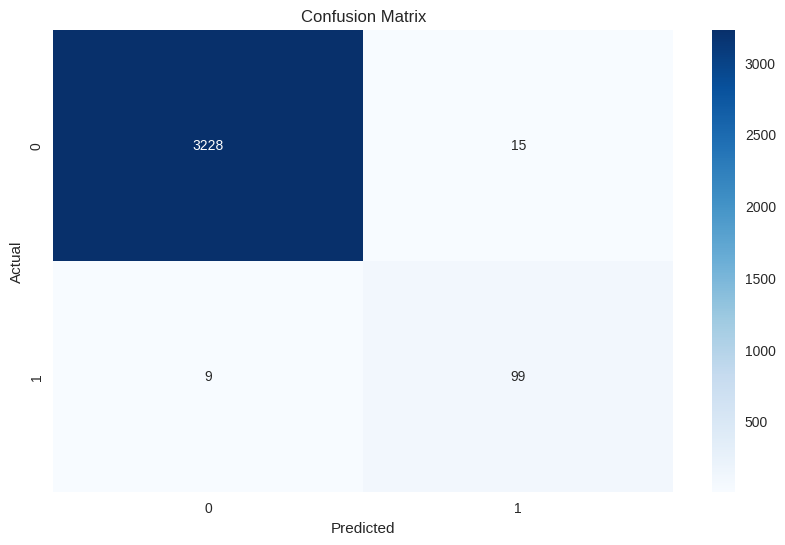

In [35]:
%%time
extra_tree_train(x_train, x_test, y_train, y_test)

roc_auc_score :  0.9606502895124542
accuracy_score:  0.9931363772008356
precision_score:  0.8695652173913043
recall_score:  0.9259259259259259
f1-score : 0.8968609865470852
confusion_matrix:  [[3228   15]
 [   8  100]]

confusion_matrix

CPU times: user 800 ms, sys: 104 ms, total: 904 ms
Wall time: 797 ms


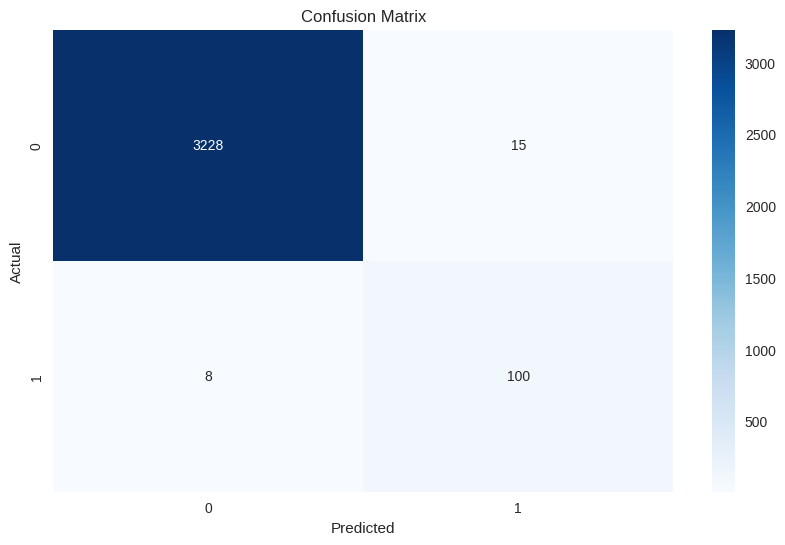

In [36]:
%%time
random_forest_classifier(x_train, x_test, y_train, y_test)

roc_auc_score :  0.9515452084832289
accuracy_score:  0.9928379588182632
precision_score:  0.875
recall_score:  0.9074074074074074
f1-score : 0.8909090909090909
confusion_matrix:  [[3229   14]
 [  10   98]]

confusion_matrix

[0.00769914 0.10172009 0.8815969  0.00898382 0.        ]
CPU times: user 1.2 s, sys: 86 ms, total: 1.29 s
Wall time: 806 ms


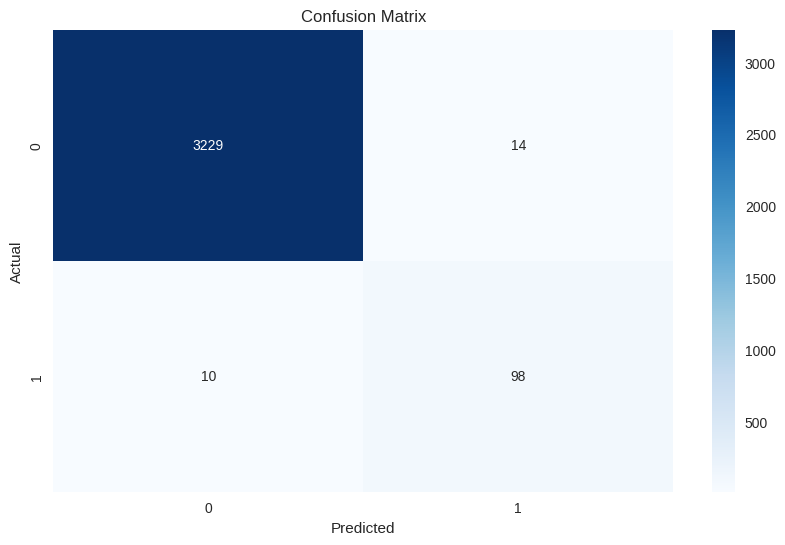

In [37]:
%%time
xgb_model = xgboost_classifier(x_train, x_test, y_train, y_test)

roc_auc_score :  0.9731729879740981
accuracy_score:  0.9480752014324082
precision_score:  0.3829787234042553
recall_score:  1.0
f1-score : 0.5538461538461539
confusion_matrix:  [[3069  174]
 [   0  108]]

confusion_matrix

CPU times: user 2.52 s, sys: 160 ms, total: 2.68 s
Wall time: 2.56 s


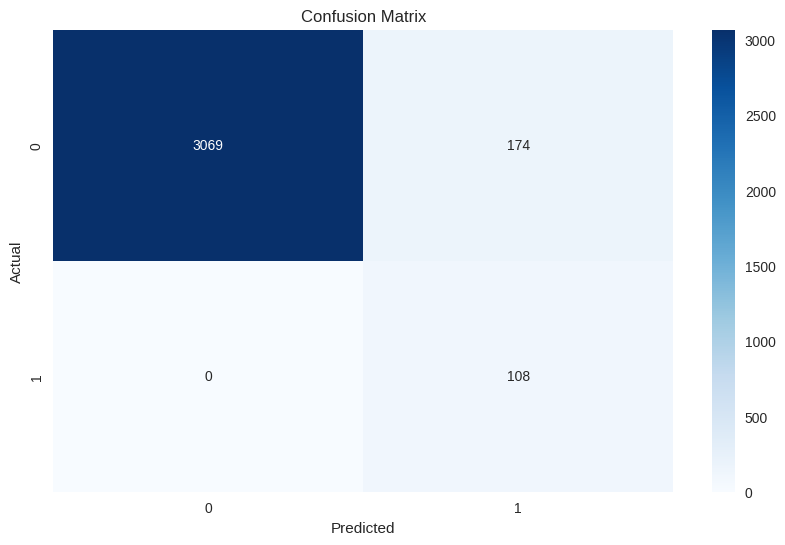

In [49]:
%%time
SVM_classifier(x_train, x_test, y_train, y_test)

# prediction

In [43]:
url = 'https://www.presstv.ir/Detail/2023/04/28/702388/\
No-trace-toxic-substances-found-schools-Iran-Intelligence-Ministry'

soup = get_html(url)
features = create_page_feature(soup)
features['normalize_depth'] = zscore(features['depth'])

features[features["label"] == 2]["label"] = 0
features['content lengh'] = features['content lengh'].astype(int)
features['depth'] = dataset['depth'].astype(int)
features['title_similarity'] = dataset['title_similarity'].astype(float)
features['normalize_depth'] = features['normalize_depth'].astype(float)
features['words in content'] = features['words in content'].astype(float)
features['label'] = features['label'].astype(bool)

X = features.drop(['label', 'content'],axis=1)
y_pred = xgb_model.predict(X)

In [44]:
main_content_index = [i for i, y in enumerate(y_pred) if y == 1]

In [45]:
main_content_index

[3]

In [46]:
features["content"].iloc[main_content_index[0]]

'In a statement released on Friday, the Intelligence Ministry laid out the final results of a thorough investigation it ran into the mysterious incidents, which started in late November in the city of Qom, where about 50 female students fell ill and had to be transported to the hospital.'